In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay,confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from model_module import model_preparation, best_model, model_preparation_multi_class
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline

In [2]:
df = pd.read_csv("./bse_eq_15min_2018_2025.csv").set_index("datetime").drop(columns=["timestamp"])

In [3]:
df

,open,high,low,close,volume
datetime,,,,,
2018-01-01 09:30:00+05:30,101.89,103.22,101.79,103.00,330300
2018-01-01 09:45:00+05:30,103.00,103.78,102.67,103.06,306486
2018-01-01 10:00:00+05:30,103.06,103.33,102.79,103.11,182691
2018-01-01 10:15:00+05:30,103.11,103.66,102.95,103.42,125217
2018-01-01 10:30:00+05:30,103.42,103.56,103.28,103.44,58653
...,...,...,...,...,...
2025-12-12 14:30:00+05:30,2731.00,2736.50,2731.00,2736.20,78913
2025-12-12 14:45:00+05:30,2736.50,2736.50,2726.50,2735.60,125254
2025-12-12 15:00:00+05:30,2735.70,2743.70,2733.50,2739.90,154848


#### Creating Technical Analysis features

    Calculate relative volume ratio

In [4]:
df = df.copy()
lookback = 20  # 20 bars = 5 hours of 15min data

df["volume_ma"] = df["volume"].rolling(window=lookback).mean()
df["volume_ratio"] = df["volume"] / df["volume_ma"]

# Clean up
df = df.dropna(how="any")

    Calculate RSI

In [5]:
# RSI calculation
def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Add RSI with standard 14-period
df["rsi_14"] = calculate_rsi(df["close"], period=14)

# Clean up
df = df.dropna(how="any")

# Check the feature
print("RSI Statistics:")
print(df["rsi_14"].describe())
print(f"\nOverbought (>70): {(df['rsi_14'] > 70).sum()} bars")
print(f"Oversold (<30): {(df['rsi_14'] < 30).sum()} bars")


RSI Statistics:
count    49024.000000
mean        48.916402
std         17.922074
min          0.000000
25%         36.000000
50%         48.840841
75%         61.587403
max         99.194210
Name: rsi_14, dtype: float64

Overbought (>70): 6523 bars
Oversold (<30): 7823 bars


In [6]:
df.head()

,open,high,low,close,volume,volume_ma,volume_ratio,rsi_14
datetime,,,,,,,,
2018-01-02 11:15:00+05:30,103.57,103.82,103.57,103.73,155808,95521.05,1.631138,51.102941
2018-01-02 11:30:00+05:30,103.73,103.89,103.69,103.89,89190,98239.05,0.907887,53.819444
2018-01-02 11:45:00+05:30,103.89,104.06,103.78,103.89,62109,100180.35,0.619972,51.985560
2018-01-02 12:00:00+05:30,103.89,103.97,103.83,103.92,22977,99982.80,0.229810,54.646840
2018-01-02 12:15:00+05:30,103.93,103.97,103.81,103.89,32706,98963.10,0.330487,61.764706


    MACD

In [7]:
# MACD calculation
def calculate_macd(data, fast=12, slow=26, signal=9):
    ema_fast = data.ewm(span=fast, adjust=False).mean()
    ema_slow = data.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    return macd_line, signal_line, macd_histogram

df["macd"], df["macd_signal"], df["macd_hist"] = calculate_macd(df["close"])

# Normalize MACD features by price (make them relative)
df["macd_norm"] = df["macd"] / df["close"]
df["macd_hist_norm"] = df["macd_hist"] / df["close"]

# Clean up
df = df.dropna(how="any")

print("MACD Statistics:")
print(df[["macd_norm", "macd_hist_norm"]].describe())

MACD Statistics:
          macd_norm  macd_hist_norm
count  49024.000000    49024.000000
mean       0.000360        0.000004
std        0.006217        0.001692
min       -0.038312       -0.021902
25%       -0.002589       -0.000732
50%       -0.000141       -0.000044
75%        0.002879        0.000658
max        0.043614        0.014145


    Volatility

    Moving averages

In [8]:
# Moving averages (just for calculation, not direct features)
df["5ma"] = df["close"].rolling(5).mean()
df["10ma"] = df["close"].rolling(10).mean()
df["50ma"] = df["close"].rolling(50).mean()
df["200ma"] = df["close"].rolling(200).mean()  # Fixed: was 100

# RELATIVE features (normalized by price)
df["5_10_ma_diff_pct"] = (df["5ma"] - df["10ma"]) / df["close"]
df["close_5ma_diff_pct"] = (df["close"] - df["5ma"]) / df["close"]
df["close_10ma_diff_pct"] = (df["close"] - df["10ma"]) / df["close"]
df["golden_cross_pct"] = (df["50ma"] - df["200ma"]) / df["close"]

# Additional useful MA features
df["close_50ma_diff_pct"] = (df["close"] - df["50ma"]) / df["close"]
df["close_200ma_diff_pct"] = (df["close"] - df["200ma"]) / df["close"]

# Slope/momentum of MAs (rate of change)
df["5ma_roc"] = df["5ma"].pct_change(periods=5)
df["50ma_roc"] = df["50ma"].pct_change(periods=10)


In [9]:
# High-Low range features
df["hl_range"] = (df["high"] - df["low"]) / df["close"]  # Normalized
df["hl_range_ma"] = df["hl_range"].rolling(20).mean()
df["hl_range_ratio"] = df["hl_range"] / df["hl_range_ma"]  # Current vs average

# Close position within bar
df["close_position"] = (df["close"] - df["low"]) / (df["high"] - df["low"])  # 0 to 1

df = df.dropna()

#### Candlestick/Microsturcture Features

In [10]:
# === CANDLESTICK BODY & WICKS ===
df["body_size"] = abs(df["close"] - df["open"]) / df["close"]
df["upper_wick"] = (df["high"] - df[["open", "close"]].max(axis=1)) / df["close"]
df["lower_wick"] = (df[["open", "close"]].min(axis=1) - df["low"]) / df["close"]

# Body direction
df["body_direction"] = np.sign(df["close"] - df["open"])

# === OPEN-CLOSE RELATIONSHIPS ===
df["open_close_diff"] = (df["close"] - df["open"]) / df["close"]
df["high_close_diff"] = (df["high"] - df["close"]) / df["close"]
df["low_close_diff"] = (df["close"] - df["low"]) / df["close"]

# === VOLUME-WEIGHTED PRICE (VWAP) ===
df["vwap_5"] = (df["close"] * df["volume"]).rolling(5).sum() / df["volume"].rolling(5).sum()
df["vwap_10"] = (df["close"] * df["volume"]).rolling(10).sum() / df["volume"].rolling(10).sum()
df["vwap_5_diff"] = (df["close"] - df["vwap_5"]) / df["close"]
df["vwap_10_diff"] = (df["close"] - df["vwap_10"]) / df["close"]

# === MOMENTUM OF MICROSTRUCTURE ===
df["close_position_change"] = df["close_position"].diff()
df["body_size_ratio"] = df["body_size"] / df["body_size"].rolling(10).mean()

# === BUYING/SELLING PRESSURE PROXIES ===
# Approximation: If close near high = buying pressure
df["buying_pressure"] = (df["close"] - df["low"]) / (df["high"] - df["low"] + 1e-10)
df["selling_pressure"] = (df["high"] - df["close"]) / (df["high"] - df["low"] + 1e-10)

# Clean up
df = df.dropna()

print(f"Added microstructure features. New shape: {df.shape}")

Added microstructure features. New shape: (48785, 44)


#### Create log returns target

In [11]:
df["close_log_return"] = np.log(df["close"] / df["close"].shift(1))
df = df.dropna(how="any")

In [12]:
df = df.copy()
df["shifted_log_return"] = df["close_log_return"].shift(-1)

#### Creating lagged features

In [13]:
df["close_log_return_lag1"] = df["shifted_log_return"].shift(1)
df["close_log_return_lag2"] = df["shifted_log_return"].shift(2)
df["close_log_return_lag3"] = df["shifted_log_return"].shift(3)
df = df.dropna(how="any")

In [14]:
df

,open,high,low,close,volume,volume_ma,volume_ratio,rsi_14,macd,macd_signal,...,vwap_10_diff,close_position_change,body_size_ratio,buying_pressure,selling_pressure,close_log_return,shifted_log_return,close_log_return_lag1,close_log_return_lag2,close_log_return_lag3
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-12 14:15:00+05:30,104.36,104.46,104.23,104.38,34290,79553.25,0.431032,38.297872,-0.084575,-0.063172,...,0.000063,0.366460,0.259816,0.652174,0.347826,0.000192,0.000383,0.000192,0.000959,-0.000671
2018-01-12 14:30:00+05:30,104.42,104.57,104.33,104.42,74088,77601.15,0.954728,37.634409,-0.077660,-0.066070,...,0.000622,-0.277174,0.000000,0.375000,0.625000,0.000383,0.000957,0.000383,0.000192,0.000959
2018-01-12 14:45:00+05:30,104.42,104.56,104.38,104.52,59004,77175.45,0.764544,43.137255,-0.063380,-0.065532,...,0.001820,0.402778,1.406335,0.777778,0.222222,0.000957,0.009522,0.000957,0.000383,0.000192
2018-01-12 15:00:00+05:30,104.52,106.11,104.41,105.52,2043855,176017.05,11.611688,71.287129,0.028302,-0.046765,...,0.003469,-0.124837,6.146111,0.652941,0.347059,0.009522,0.017008,0.009522,0.000957,0.000383
2018-01-12 15:15:00+05:30,105.46,107.48,105.09,107.33,2132487,280313.10,7.607518,84.816754,0.244198,0.011428,...,0.010968,0.284297,5.759014,0.937238,0.062762,0.017008,-0.002145,0.017008,0.009522,0.000957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-12 14:15:00+05:30,2731.80,2737.30,2731.00,2731.00,114859,153149.45,0.749980,89.243697,12.722016,11.922257,...,0.002252,-0.476190,0.279830,0.000000,1.000000,-0.000183,0.001902,-0.000183,0.000842,0.000696
2025-12-12 14:30:00+05:30,2731.00,2736.50,2731.00,2736.20,78913,128614.20,0.613564,88.652482,12.969928,12.131792,...,0.003383,0.945455,2.048542,0.945455,0.054545,0.001902,-0.000219,0.001902,-0.000183,0.000842
2025-12-12 14:45:00+05:30,2736.50,2736.50,2726.50,2735.60,125254,118641.35,1.055736,90.252708,12.968492,12.299132,...,0.002446,-0.035455,0.374042,0.910000,0.090000,-0.000219,0.001571,-0.000219,0.001902,-0.000183


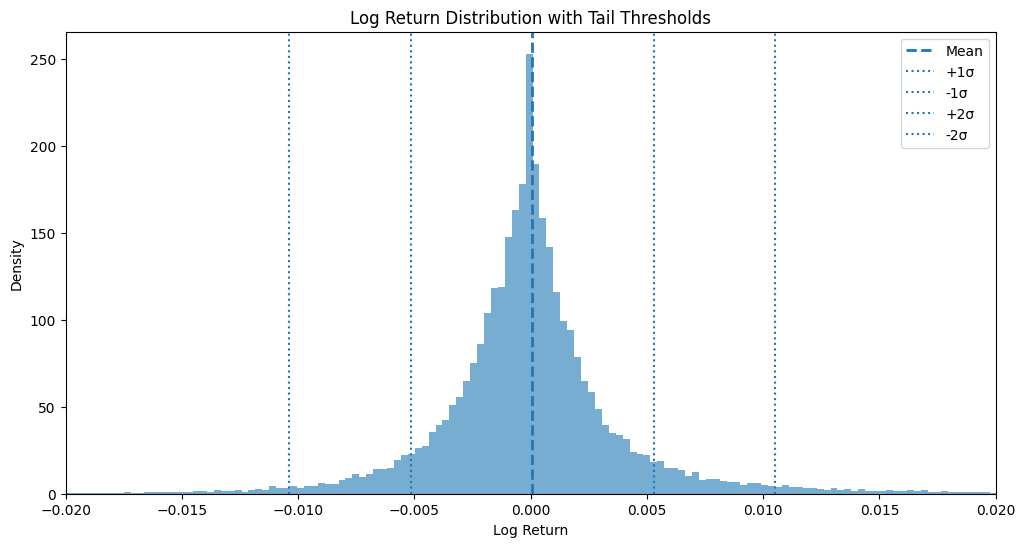

In [15]:
y_clean = df["close_log_return"].dropna()

mu = y_clean.mean()
sigma = y_clean.std()

fig, ax = plt.subplots(figsize=(12, 6))

# Histogram
ax.hist(
    y_clean,
    bins=1000,
    density=True,
    alpha=0.6
)
ax.set_xlim(-0.02, 0.02)
# Mean & std lines
ax.axvline(mu, linestyle="--", linewidth=2, label="Mean")
ax.axvline(mu + sigma, linestyle=":", linewidth=1.5, label="+1σ")
ax.axvline(mu - sigma, linestyle=":", linewidth=1.5, label="-1σ")
ax.axvline(mu + 2*sigma, linestyle=":", linewidth=1.5, label="+2σ")
ax.axvline(mu - 2*sigma, linestyle=":", linewidth=1.5, label="-2σ")


ax.set_title("Log Return Distribution with Tail Thresholds")
ax.set_xlabel("Log Return")
ax.set_ylabel("Density")

ax.legend(loc="upper right")
plt.show()


In [16]:
X = df[[
    "buying_pressure",
    "selling_pressure",
    "close_position",
    "close_5ma_diff_pct",
    "high_close_diff",
    "vwap_5_diff",
    "body_size",
    "body_size_ratio",
    "volume_ratio",
    "low_close_diff"
]]


# y = (df["shifted_log_return"] > 0).astype(int)
